# 练习4：神经网络

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.misc #Used to show matrix as an image
import matplotlib
import random #To pick random images to display
import scipy.optimize as opt #fmin_cg to train neural network
import itertools
from scipy.special import expit #Vectorized sigmoid function
from scipy.io import loadmat

## 查看数据

与练习3的数据集相同

In [2]:
data = loadmat('./data/ex4data1.mat')
X = data['X']
y = data['y']
# np.transpose(y)
X.shape, y.shape

((5000, 400), (5000, 1))

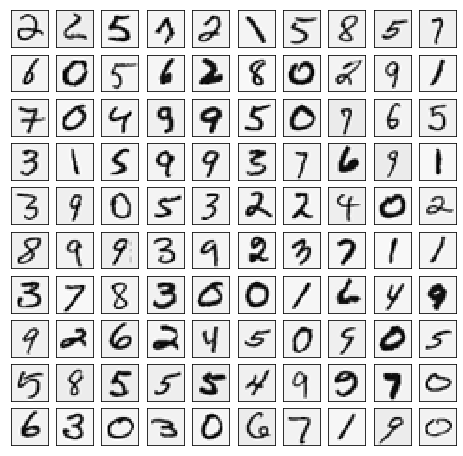

In [3]:
def plot_100_image(X):
    """ sample 100 image and show them
    assume the image is square

    X : (5000, 400)
    """
    
    # 需要对 X 进行转置
    X = np.array([im.reshape((20, 20)).T for im in X])
    X = np.array([im.reshape(400) for im in X])
    
    size = int(np.sqrt(X.shape[1]))
    # sample 100 image, reshape, reorg it
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # 100*400
    sample_images = X[sample_idx, :]

    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))

    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))  

# 显示100个样本           
plot_100_image(X)
plt.show()

## 模型初始化

### 读取权重

In [4]:
thetas = loadmat('./data/ex4weights.mat')
theta1 = thetas['Theta1']
theta2 = thetas['Theta2']

theta1.shape, theta2.shape

((25, 401), (10, 26))

### 对目标 y 进行独热编码，对X增加$x_0$列 

In [5]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)

X = np.insert(X,0,1,axis=1)
X.shape, y_onehot.shape

((5000, 401), (5000, 10))

### Sigmoid函数

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

## Feedforward Propagation 前向传播

In [7]:
def FP(X, theta_list):
    z_a_list = []    
    a = np.matrix(X)
    for (i, theta) in enumerate(theta_list):
        theta = np.matrix(theta)
        z = a * theta.T
        a = sigmoid(z)
        if i != (len(theta_list)-1):
            a = np.insert(a,0,1,axis=1)
        z_a_list.append((z,a))
            
    pred = np.argmax(a, axis=1) + 1
    return z_a_list,pred        

### 代价函数

<img style="float: left;" src="./img/nn_cost.png">



### 正则化代价函数
<img style="float: left;" src="./img/nn_regcost.png">

In [8]:
def reshape_theta(flattened_theta):
    theta1 = flattened_theta[:(25*401)].reshape(25,401)
    theta2 = flattened_theta[(25*401):].reshape(10,26)
    theta1 = np.array(theta1)
    theta2 = np.array(theta2)
    return [theta1,theta2]

In [9]:
# 计算代价函数
def nnCostFunction(flattened_theta,X, y,mylambda=0.):
    theta_list = reshape_theta(flattened_theta)
    m = X.shape[0]
    y = np.matrix(y)
    z_a_list,h = FP(X, theta_list)
    myh = z_a_list[-1][1]
    cost = np.multiply(-y,np.log(myh)) - np.multiply((1-y),np.log(1-myh))
    # 计算正则项
    reg = 0.
    if mylambda != 0.:
        for theta in theta_list:
            reg +=  np.power(theta[:, 1:], 2).sum()
        reg = (mylambda / (2*m)) * reg
    
    return np.sum(cost)/m + reg

In [10]:
flattened_theta = np.concatenate((theta1.flatten(),theta2.flatten()))
# 未正则化的代价
nnCostFunction(flattened_theta,X, y_onehot)

0.2876291651613189

In [11]:
# 正则化的代价
nnCostFunction(flattened_theta, X, y_onehot, mylambda=1.)

0.38376985909092365

## Back propagation反向传播

### Sigmoid Gradient

In [12]:
def sigmoidGradient(z):
    return np.multiply(sigmoid(z),1-sigmoid(z))

In [13]:
sigmoidGradient(0)

0.25

### Random initialization 随机初始化权重参数

In [14]:
def randInitializeWeights(size):
    epsilon_init = 0.12
    return np.random.uniform(-epsilon_init, epsilon_init, size)

In [15]:
init_theta = randInitializeWeights(10285)  # 25*401 + 10*26

### 反向传播

包含正则化

In [16]:
def backPropagate(flattened_theta,X,y,mylambda=0.):
    theta_list = reshape_theta(flattened_theta)
    # 初始化
    X = np.matrix(X) # (5000,401)
    y = np.matrix(y) # (5000,10)
    t1 = np.matrix(theta_list[0]) # (25,401)
    t2 = np.matrix(theta_list[1]) # (10,26)
    
    m = X.shape[0]
    
    delta1 = np.zeros(t1.shape)  # (25, 401)
    delta2 = np.zeros(t2.shape)  # (10, 26)

    z_a_list,h = FP(X, theta_list)
    a1 = X # (5000,401)
    z2 = z_a_list[0][0] # (5000,25)
    a2 = z_a_list[0][1] #(5000,26)
    z3 = z_a_list[1][0] #(5000,10)
    a3 = z_a_list[1][1] #(5000,10)

    for i in range(m):
        a1i = a1[i, :]  # (1, 401)
        z2i = z2[i, :]  # (1, 25)
        a2i = a2[i, :]  # (1, 26)
        a3i = a3[i, :]    # (1, 10)
        yi = y[i, :]    # (1, 10)

        d3i = a3i - yi  # (1, 10)
        z2i = np.insert(z2i, 0, np.ones(1))  # make it (1, 26) to compute d2i
        d2i = np.multiply(d3i * t2, sigmoidGradient(z2i))  # (1, 26)
    
        delta2 += d3i.T * a2i  # (1, 10).T @ (1, 26) -> (10, 26)
        delta1 += d2i[:,1:].T * a1i
    delta1 = delta1 / m
    delta2 = delta2 / m

    # 正则化
    delta1[:,1:] += (mylambda/m ) * t1[:,1:]
    delta2[:,1:] += (mylambda/m ) * t2[:,1:]
    
    flattened_delta = np.concatenate((delta1.flatten(),delta2.flatten()))
    return flattened_delta  

In [36]:
flattened_delta = backPropagate(flattened_theta, X, y_onehot)
delta = reshape_theta(flattened_delta)
delta[0].shape, delta[1].shape

((25, 401), (10, 26))

### Gradient checking 梯度检验

<img src="./img/nn_gradient_checking.png" style="max-height: 70%;max-width:80%">

In [41]:
def checkGradient(flattened_theta,flattened_delta,X,y,mylambda=0.):
    myeps = 0.0001
    flattened_X = X.flatten()
    n_elems = len(flattened_theta) 
    flattened_theta = np.reshape(flattened_theta,(n_elems,1))
    #随机计算10次，检验梯度是否与我们手动求导计算的一样
    for i in range(10):
        # 随机选个epsvec位置
        x = int(np.random.rand() * n_elems)
        epsvec = np.zeros((n_elems,1))
        epsvec[x] = myeps
        
        theta_plus = flattened_theta + epsvec
        theta_minus = flattened_theta - epsvec
        cost_plus = nnCostFunction(theta_plus,X,y,mylambda)
        cost_minus  = nnCostFunction(theta_minus,X,y,mylambda)
        
        mygrad = (cost_plus - cost_minus) / float(2*myeps)
        print ("Element: %d. Numerical Gradient = %f. BackProp Gradient = %f."%(x,mygrad,flattened_delta[x]))

In [42]:
checkGradient(flattened_theta,flattened_delta,X,y_onehot)

Element: 6731. Numerical Gradient = 0.000053. BackProp Gradient = 0.000053.
Element: 10114. Numerical Gradient = -0.000201. BackProp Gradient = -0.000201.
Element: 9303. Numerical Gradient = 0.000003. BackProp Gradient = 0.000003.
Element: 1945. Numerical Gradient = 0.000000. BackProp Gradient = 0.000000.
Element: 1265. Numerical Gradient = 0.000000. BackProp Gradient = 0.000000.
Element: 1688. Numerical Gradient = -0.000029. BackProp Gradient = -0.000029.
Element: 9942. Numerical Gradient = 0.000004. BackProp Gradient = 0.000004.
Element: 3330. Numerical Gradient = 0.000003. BackProp Gradient = 0.000003.
Element: 4517. Numerical Gradient = -0.000048. BackProp Gradient = -0.000048.
Element: 4751. Numerical Gradient = -0.000005. BackProp Gradient = -0.000005.


### Learning parameters using fmincg
开始优化参数

In [18]:
def fmincg_nn(X,y,init_theta,mylambda=0.):
    res = opt.fmin_cg(f=nnCostFunction, 
                      x0=init_theta, 
                      fprime=backPropagate, 
                      args=(X, y,mylambda), 
                      maxiter=100, 
                      full_output=True)
    return res[0]

In [19]:
final_theta = fmincg_nn(X,y_onehot,init_theta,1.)

         Current function value: 0.359566
         Iterations: 100
         Function evaluations: 232
         Gradient evaluations: 232


### 预测准确度

In [20]:
final_theta_list = reshape_theta(final_theta)
z_a_list,pred = FP(X, final_theta_list)
# 注意这里是和没经过onehot编码的y进行比较
correct = [1 if a == b else 0 for (a, b) in zip(pred,y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print ('accuracy = {0}%'.format(accuracy * 100))

accuracy = 98.22%


### Visualizing the hidden layer可视化隐藏层

In [21]:
def plot_hidden_layer(final_theta):
    final_theta_list = reshape_theta(final_theta)
    final_theta1 = final_theta_list[0]
    final_theta2 = final_theta_list[1]
    hidden_layer = final_theta1[:, 1:]  # ger rid of bias term theta

    fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(5, 5))

    for r in range(5):
        for c in range(5):
            ax_array[r, c].matshow(hidden_layer[5 * r + c].reshape((20, 20)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

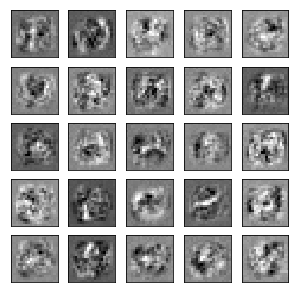

In [22]:
plot_hidden_layer(final_theta)
plt.show()